In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('Mumbai_House_Price.csv');
df

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New
...,...,...,...,...,...,...,...,...,...
76033,3,Apartment,Parinee Liva Roca,1527,7.00,Cr,Juhu,Ready to move,Unknown
76034,5,Apartment,Parinee Liva Roca,3049,12.00,Cr,Juhu,Ready to move,Unknown
76035,4,Apartment,Lodha Seaview,3313,10.00,Cr,Napeansea Road,Ready to move,Unknown
76036,2,Apartment,Hubtown Serene,1305,4.25,Cr,Bandra East,Ready to move,Unknown


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [3]:
def convert_price(data):
    for r in range(data.shape[0]):
        price = data.loc[r,'price']
        if data.loc[r, 'price_unit']== 'L':
            data.loc[r, 'price'] = price *100000*0.012
        if data.loc[r, 'price_unit']== 'Cr':
            data.loc[r,'price'] = price*10000000*0.012
    return data
df = convert_price(df)
df.drop(['price_unit'],axis='columns', inplace=True)

In [4]:
print(f"Before deleting NULL value in columns \"age\": {df.shape}")
df = df.replace('Unknown', np.nan)
df.dropna(inplace=True)
print(f"After deleting NULL value in columns \"age\": {df.shape}")

Before deleting NULL value in columns "age": (76038, 8)
After deleting NULL value in columns "age": (61429, 8)


In [5]:
print(f"Before deleting duplicated row: {df.shape}")
df.drop_duplicates(inplace=True)
print(f"After deleting duplicated row: {df.shape}")

Before deleting duplicated row: (61429, 8)
After deleting duplicated row: (47191, 8)


In [6]:
df['price_per_sqft'] = df['price']/df['area']

<Axes: >

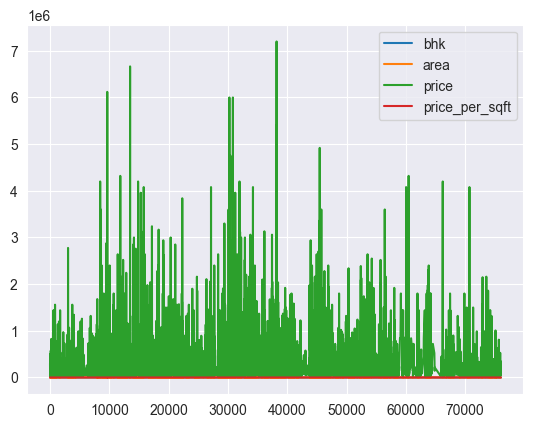

In [7]:
df.plot()

In [8]:
for col in df.columns:
    if(df[col].dtype == 'object'): 
        df[col] = df[col].apply(lambda x : x.strip())
        print(df[col].value_counts())
        print(f"Total number of different values for \"{col}\" columns: {len(df[col].unique())}")
        #print(f"Set of values in \"{col}\" column: {df[col].unique()}")
        print("-"*30)

type
Apartment            46268
Studio Apartment       710
Villa                  154
Independent House       59
Name: count, dtype: int64
Total number of different values for "type" columns: 4
------------------------------
locality
JP North Barcelona                251
Amar Vinay Heritage               196
Raj Akshay                        193
JP Codename Dream Home Tower B    192
Lodha Codename Premier            172
                                 ... 
Stark K Raheja Residency            1
Shreeji Thakare Complex             1
Reputed Builder Sea Lord            1
S Raheja Jal Kiran CHS              1
Fortune Classique                   1
Name: count, Length: 8551, dtype: int64
Total number of different values for "locality" columns: 8551
------------------------------
region
Mira Road East    7642
Thane West        5720
Dombivali         1957
Kandivali East    1616
Kharghar          1574
                  ... 
Tilak Nagar          1
Ashok nagar          1
Antop Hill           1
P

In [9]:
stats =  df['region'].value_counts(ascending=False)
print(stats)
max = df['region'].value_counts().max()
print(max)
tmp = stats.to_list()/max
stats_to_change = stats[stats<=11]
stats_to_change
def convert(region):
    if region in stats_to_change:
        return 'Others'
    return region
df1 = df.copy()
df1.region = df1.region.apply(convert)
df1.region.unique()
df1['region'].value_counts(ascending=False)
df1 = df1.replace('Others', np.nan)
df1.dropna(inplace=True)
df1.shape

region
Mira Road East    7642
Thane West        5720
Dombivali         1957
Kandivali East    1616
Kharghar          1574
                  ... 
Tilak Nagar          1
Ashok nagar          1
Antop Hill           1
Peddar Road          1
L I C Colony         1
Name: count, Length: 205, dtype: int64
7642


(46908, 9)

C:\Users\phand\AppData\Local\Temp\ipykernel_6368\1941712194.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['price_per_sqft'])


<Axes: xlabel='price_per_sqft', ylabel='Density'>

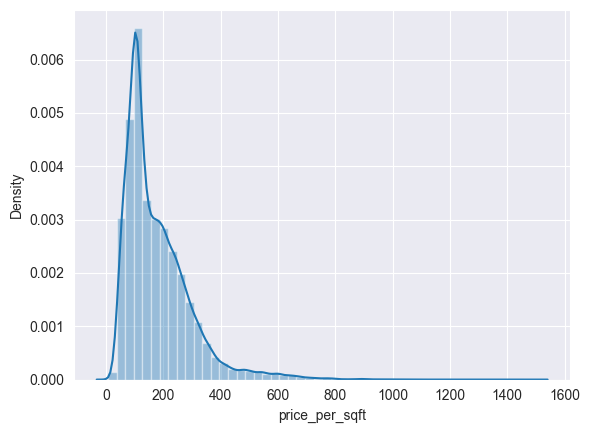

In [10]:
sns.distplot(df1['price_per_sqft'])

<Axes: ylabel='price_per_sqft'>

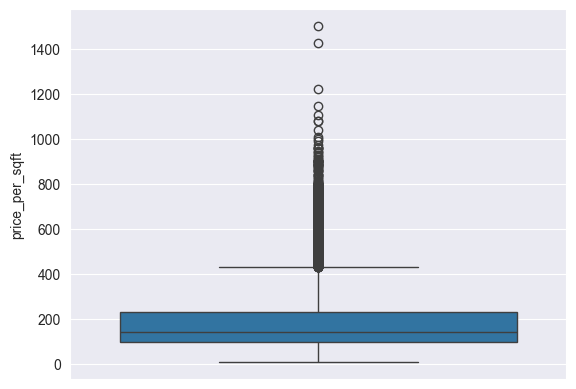

In [11]:
sns.boxplot(df1['price_per_sqft'])

In [12]:
#IQR 
q1 = df1['price_per_sqft'].quantile(0.25)
q3 = df1['price_per_sqft'].quantile(0.75)
iqr = q3-q1
q1, q3, iqr

upperlimit = q3+(1.5*iqr)
lowerlimit = q1-(1.5)*iqr
lowerlimit, upperlimit

df2 = df1.loc[(df['price_per_sqft']<upperlimit)&(df['price_per_sqft']>lowerlimit)] 
df2.shape

(45195, 9)

<Axes: ylabel='price_per_sqft'>

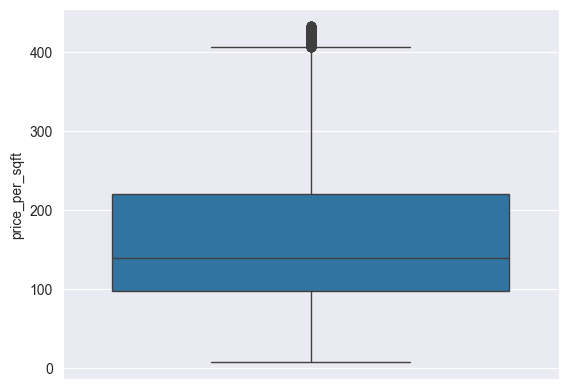

In [13]:
sns.boxplot(df2['price_per_sqft'])

C:\Users\phand\AppData\Local\Temp\ipykernel_6368\749345915.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['price_per_sqft'])


<Axes: xlabel='price_per_sqft', ylabel='Density'>

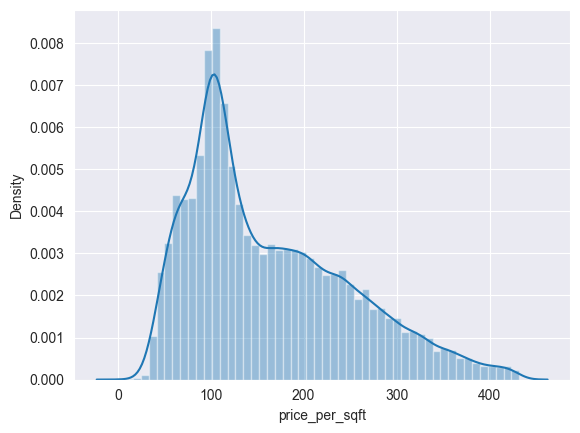

In [14]:
sns.distplot(df2['price_per_sqft'])

In [15]:
upperlimit = df1['price_per_sqft'].quantile(0.99)
lowerlimit = df1['price_per_sqft'].quantile(0.01)
df3 = df.loc[(df1['price_per_sqft']<upperlimit)&(df['price_per_sqft']>lowerlimit)] 
df3.shape

(45968, 9)

<Axes: ylabel='price_per_sqft'>

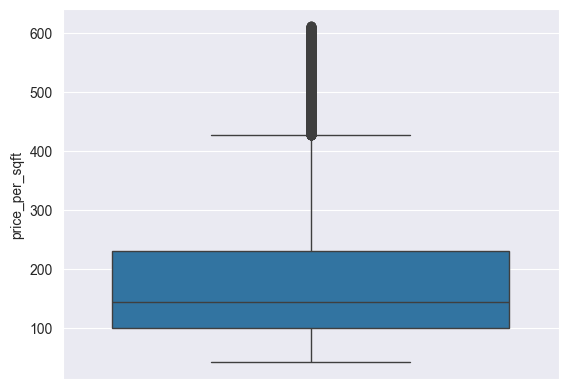

In [16]:
sns.boxplot(df3['price_per_sqft'])


C:\Users\phand\AppData\Local\Temp\ipykernel_6368\2335134006.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3['price_per_sqft'])


<Axes: xlabel='price_per_sqft', ylabel='Density'>

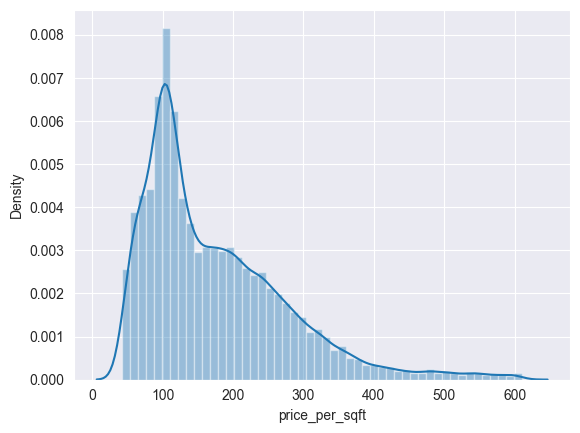

In [17]:
sns.distplot(df3['price_per_sqft'])

In [18]:
col = ['type', 'status', 'age', 'region']
#ohe = OneHotEncoder()
ohe = pd.get_dummies(df3, columns=col, dtype=float)
ohe.shape
ohe.drop(columns=['price_per_sqft', 'locality'], inplace=True)

In [19]:
max_values = {}
numberic_cols = ['bhk', 'area', 'price']
for col in numberic_cols:
    max_v = ohe[col].max()
    max_values.update({col: max_v})
    ohe[col] = (ohe[col] - ohe[col].min()) / (ohe[col].max() - ohe[col].min())
x = ohe.drop(columns=['price'])
y = ohe['price']

In [20]:
import tensorflow as tf
import keras
from keras import layers, optimizers

In [21]:
def custom_dense(unit=128, activation='relu', bias=True, batch_norm=True):
    def _custom_dense(input):
        x = layers.Dense(unit, activation, bias)(input)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        return x
    return _custom_dense

def simple_ANN(att_dims):
    input = keras.Input(shape= (att_dims, ), name='ANN_input')
    x = custom_dense(256, batch_norm=True)(input)
    x = custom_dense(128, batch_norm=True)(x)
    x = custom_dense(64, batch_norm=True)(x)
    x = custom_dense(32, batch_norm=True)(x)
    x = layers.Dropout(0.3)(x)
    output = custom_dense(1, 'sigmoid', batch_norm=False)(x)
    model = keras.Model(input, output, name='Simple_ANN')
    model.summary()
    return model

In [22]:
dim = x.shape[1]
model = simple_ANN(dim)
# Compile model
model.compile(
        loss=keras.losses.MeanAbsoluteError(),
        optimizer=keras.optimizers.Adam(0.001),
        metrics=[keras.metrics.R2Score()],
)

Model: "Simple_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ANN_input (InputLayer)      [(None, 116)]             0         
                                                                 
 dense (Dense)               (None, 256)               29952     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [23]:
train_size = int(x.shape[0] * 0.8)

train_data = x[:train_size]
train_label = y[:train_size]
test_data = x[train_size:]
test_label = y[train_size:]

print(train_data.shape)
print(test_data.shape)

(36774, 116)
(9194, 116)


In [24]:
EPOCHS = 200
BATCH_SIZE = 256
# Train model 
history = model.fit(train_data, train_label, BATCH_SIZE, EPOCHS, validation_split=0.2, shuffle=True)

Epoch 1/200
115/115 [==============================] - 2s 6ms/step - loss: 0.2357 - r2_score: -69.2586 - val_loss: 0.0821 - val_r2_score: -2.5133
Epoch 2/200
115/115 [==============================] - 0s 4ms/step - loss: 0.1683 - r2_score: -59.0874 - val_loss: 0.0691 - val_r2_score: -4.5389
Epoch 3/200
115/115 [==============================] - 0s 4ms/step - loss: 0.1642 - r2_score: -58.3612 - val_loss: 0.1282 - val_r2_score: -27.6123
Epoch 4/200
115/115 [==============================] - 0s 4ms/step - loss: 0.1253 - r2_score: -41.3798 - val_loss: 0.1339 - val_r2_score: -41.4641
Epoch 5/200
115/115 [==============================] - 0s 4ms/step - loss: 0.1012 - r2_score: -32.9339 - val_loss: 0.1266 - val_r2_score: -40.9841
Epoch 6/200
115/115 [==============================] - 0s 4ms/step - loss: 0.0994 - r2_score: -32.6519 - val_loss: 0.1256 - val_r2_score: -40.9467
Epoch 7/200
115/115 [==============================] - 0s 4ms/step - loss: 0.0970 - r2_score: -31.5736 - val_loss: 0.112

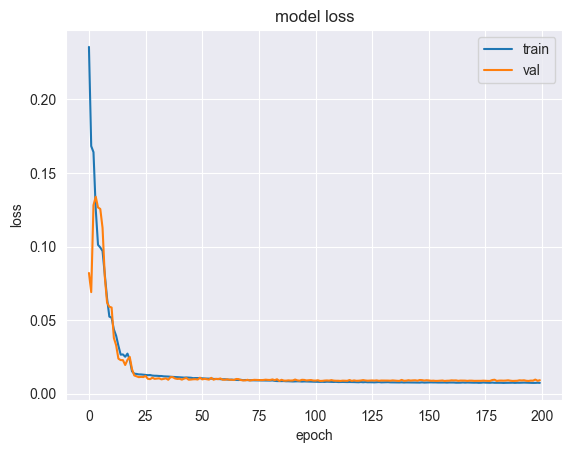

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [26]:
model.evaluate(test_data, test_label)

288/288 [==============================] - 0s 829us/step - loss: 0.0084 - r2_score: 0.8586


[0.008384921588003635, 0.8586405515670776]